In [2]:
import pandas as pd
from pandas import ExcelWriter
%matplotlib inline

In [10]:
from datetime import datetime 
import time 

btc_df = pd.read_csv('../data/BTC/BTC_2012-2018_1min.csv')
btc_df["Date(UTC)"] = pd.to_datetime(btc_df["Timestamp"], utc=True,unit='s')

google_trends_df = pd.read_csv('C:/Users/Shoya/surf/data/CryptoGoogleTrends_v2.csv', encoding='latin1')
google_trends_df["date"] = pd.to_datetime(google_trends_df["date"])
google_trends_df['Date_UTC_trend'] = google_trends_df['date'].dt.tz_localize('EST').dt.tz_convert('UTC')
google_trends_df["Timestamp"] = [time.mktime(t.timetuple()) for t in google_trends_df.Date_UTC_trend]

google_trends_bitcoin_historical_df = pd.read_csv('C:/Users/Shoya/surf/data/GoogleTrendsHistorical.csv', encoding='latin1')
google_trends_bitcoin_historical_df["Week"] = pd.to_datetime(google_trends_bitcoin_historical_df["Week"])
google_trends_bitcoin_historical_df["Timestamp"] = [time.mktime(t.timetuple()) for t in google_trends_bitcoin_historical_df.Week]

# weigh Google Trends Hourly data using the Historical Data

def weigh_using_historical_data():
    pass
    # use this function and pass to the dataframe using .apply




display(google_trends_bitcoin_historical_df.head())
display(btc_df.head())
display(btc_df.tail())
display(google_trends_df.head())
display(google_trends_df.tail())

,Week,bitcoin: (Worldwide),Timestamp
0,2015-01-04,2,1.420348e+09
1,2015-01-11,3,1.420952e+09
2,2015-01-18,2,1.421557e+09
3,2015-01-25,2,1.422162e+09
4,2015-02-01,2,1.422767e+09


,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price,Date(UTC)
0,1325317920,4.39,4.39,4.39,4.39,0.455581,2.0,4.39,2011-12-31 07:52:00
1,1325317980,4.39,4.39,4.39,4.39,0.455581,2.0,4.39,2011-12-31 07:53:00
2,1325318040,4.39,4.39,4.39,4.39,0.455581,2.0,4.39,2011-12-31 07:54:00
3,1325318100,4.39,4.39,4.39,4.39,0.455581,2.0,4.39,2011-12-31 07:55:00
4,1325318160,4.39,4.39,4.39,4.39,0.455581,2.0,4.39,2011-12-31 07:56:00


,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price,Date(UTC)
3273372,1522108560,8159.21,8159.39,8153.62,8153.68,0.663192,5408.215377,8154.826880,2018-03-26 23:56:00
3273373,1522108620,8159.38,8163.72,8152.81,8155.00,3.720024,30333.753144,8154.182788,2018-03-26 23:57:00
3273374,1522108680,8157.47,8158.60,8130.01,8130.01,27.294436,222388.761970,8147.769162,2018-03-26 23:58:00
3273375,1522108740,8145.17,8149.66,8130.01,8149.66,23.065281,187570.784940,8132.169837,2018-03-26 23:59:00
3273376,1522108800,8152.26,8164.68,8151.37,8153.04,17.758130,144820.147410,8155.146220,2018-03-27 00:00:00


,date,Bitcoin,Ethereum,Bitstamp,Buy Bitcoin,Coinbase,isPartial,Date_UTC_trend,Timestamp
0,2015-01-06 00:00:00,79,1,7,2,2,False,2015-01-06 05:00:00+00:00,1.420538e+09
1,2015-01-06 01:00:00,63,1,6,2,2,False,2015-01-06 06:00:00+00:00,1.420542e+09
2,2015-01-06 02:00:00,67,1,5,2,2,False,2015-01-06 07:00:00+00:00,1.420546e+09
3,2015-01-06 03:00:00,57,0,5,1,1,False,2015-01-06 08:00:00+00:00,1.420549e+09
4,2015-01-06 04:00:00,56,1,6,2,2,False,2015-01-06 09:00:00+00:00,1.420553e+09


,date,Bitcoin,Ethereum,Bitstamp,Buy Bitcoin,Coinbase,isPartial,Date_UTC_trend,Timestamp
29755,2018-05-29 19:00:00,75,9,1,2,6,False,2018-05-30 00:00:00+00:00,1.527656e+09
29756,2018-05-29 20:00:00,77,9,1,1,6,False,2018-05-30 01:00:00+00:00,1.527660e+09
29757,2018-05-29 21:00:00,79,9,1,1,6,False,2018-05-30 02:00:00+00:00,1.527664e+09
29758,2018-05-29 22:00:00,76,9,1,2,7,False,2018-05-30 03:00:00+00:00,1.527667e+09
29759,2018-05-29 23:00:00,71,8,0,1,6,False,2018-05-30 04:00:00+00:00,1.527671e+09


,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price,Date(UTC),date,Bitcoin,Ethereum,Bitstamp,Buy Bitcoin,Coinbase,isPartial,Date(UTC)_trend
0,1420840800,289.59,289.94,289.13,289.13,34.042422,9854.490388,289.476771,2015-01-09 22:00:00,2015-01-09 17:00:00,53,0,6,1,1,False,2015-01-09 22:00:00+00:00
1,1420844400,293.61,293.61,292.15,292.15,36.628012,10733.474257,293.040042,2015-01-09 23:00:00,2015-01-09 18:00:00,52,0,7,1,1,False,2015-01-09 23:00:00+00:00
2,1420848000,293.89,293.89,293.89,293.89,0.158015,46.439149,293.890000,2015-01-10 00:00:00,2015-01-09 19:00:00,52,0,7,1,2,False,2015-01-10 00:00:00+00:00
3,1420851600,289.20,289.20,289.10,289.10,30.985828,8960.344674,289.175573,2015-01-10 01:00:00,2015-01-09 20:00:00,56,0,8,1,2,False,2015-01-10 01:00:00+00:00
4,1420855200,289.18,289.18,288.57,288.59,7.694195,2224.105007,289.062740,2015-01-10 02:00:00,2015-01-09 21:00:00,53,0,9,1,2,False,2015-01-10 02:00:00+00:00


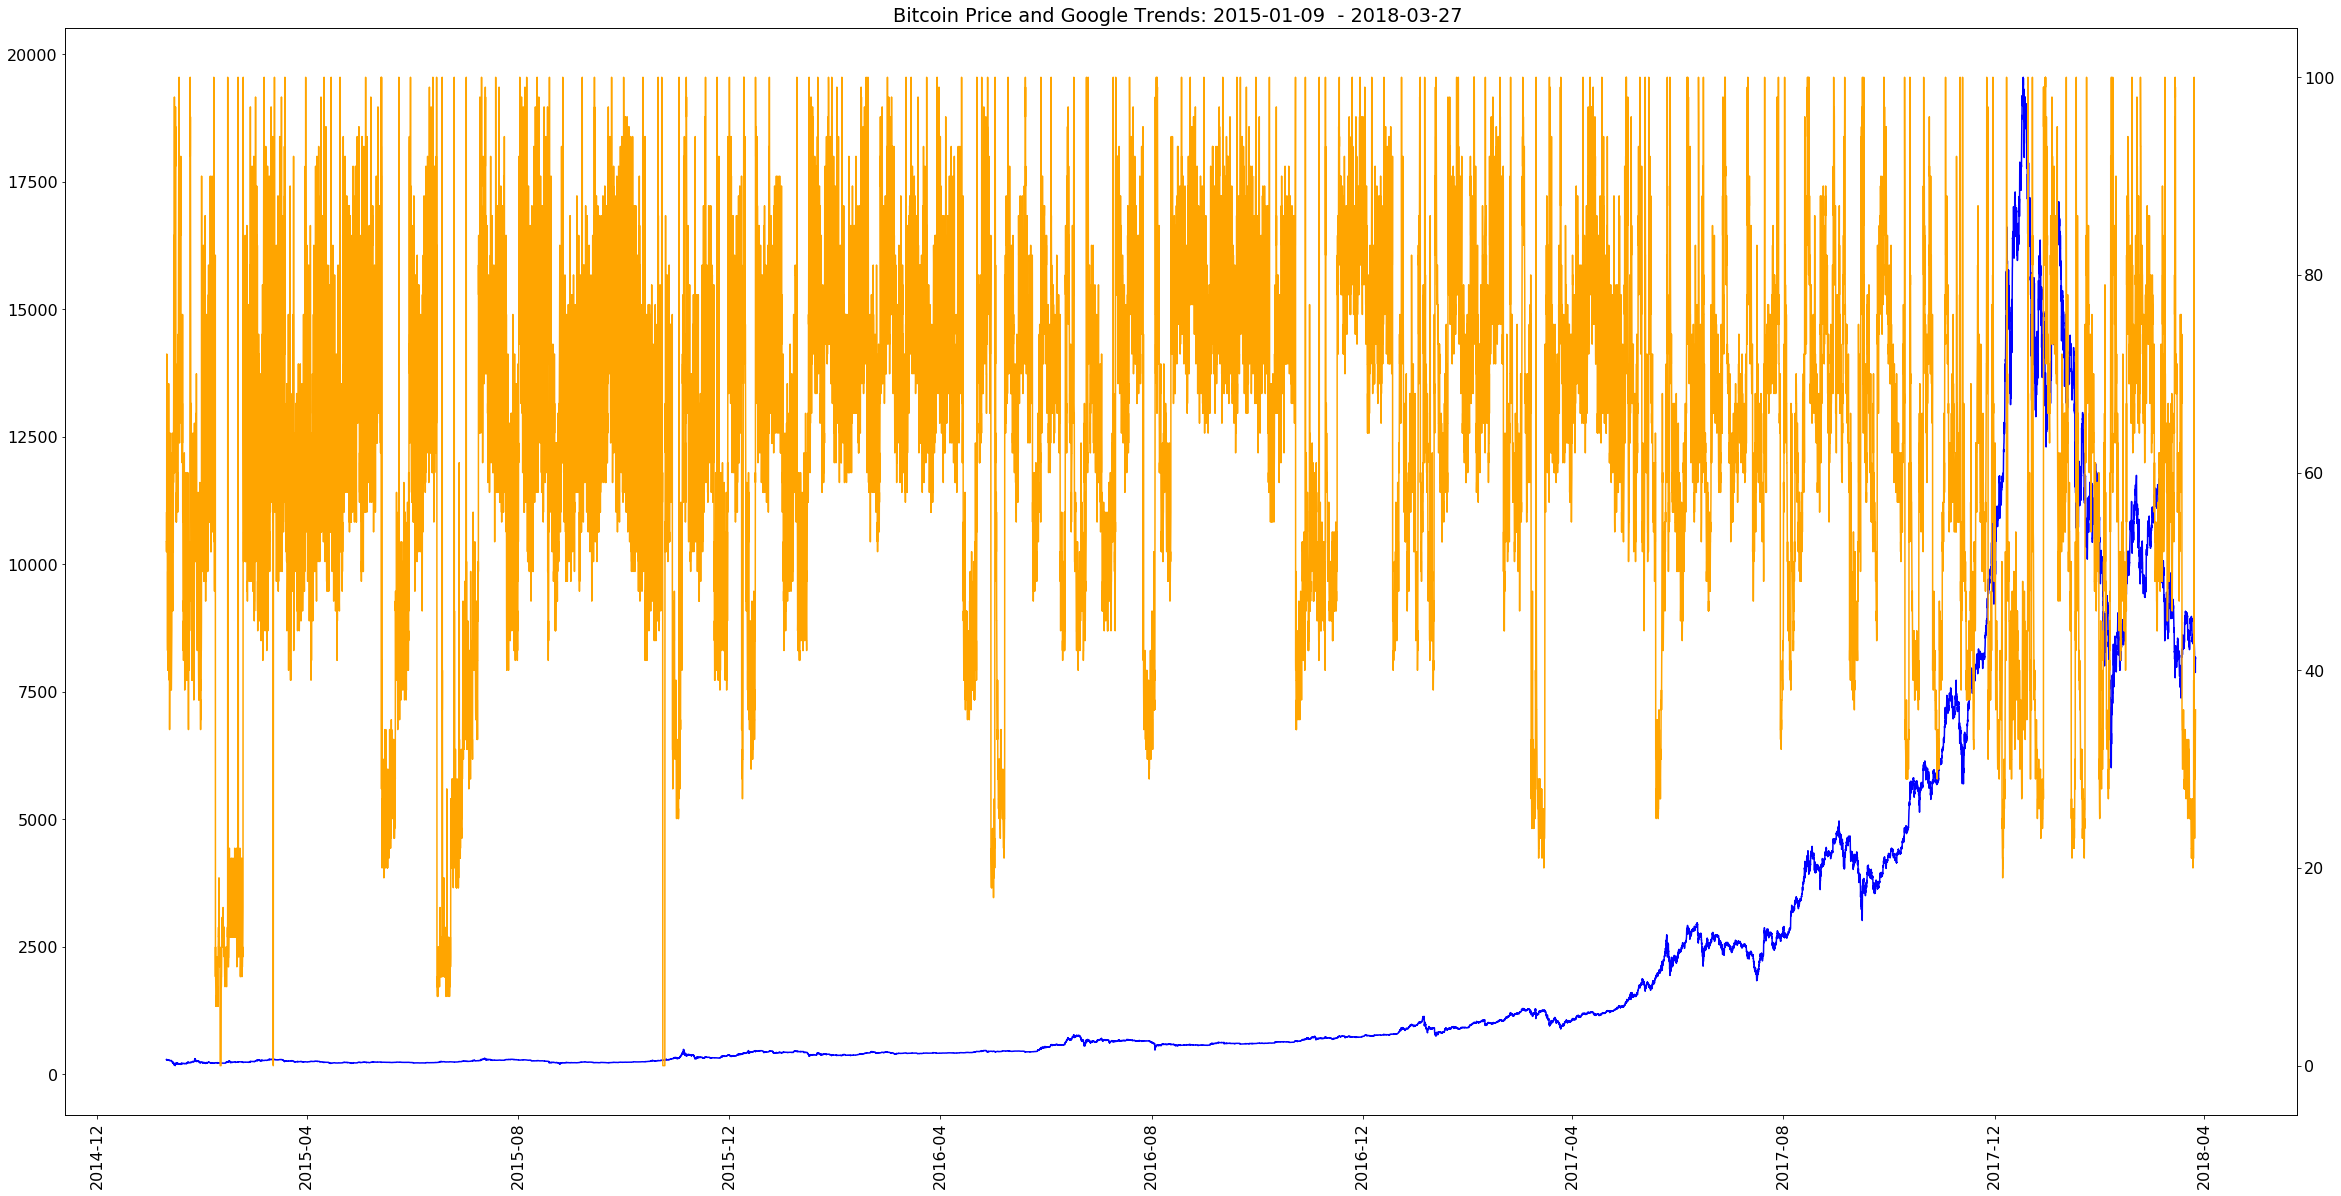

In [23]:
import matplotlib.pyplot as plt

btc_and_trends_df_hourly = pd.merge(left=btc_df, left_on="Timestamp", right=google_trends_df, right_on="Timestamp")
display(btc_and_trends_df_hourly.head())

fig_bitcoin_overall, ax_bitcoin_overall = plt.subplots(figsize=(40,20)) 
ax_bitcoin_overall.plot(btc_and_trends_df_hourly["Date(UTC)"], btc_and_trends_df_hourly["Close"], color='blue')
ax_bitcoin_overall_2 = ax_bitcoin_overall.twinx() 
ax_bitcoin_overall_2.plot(btc_and_trends_df_hourly["Date(UTC)"], btc_and_trends_df_hourly["Bitcoin"], color='orange' )
ax_bitcoin_overall.set_title('Bitcoin Price and Google Trends: ' + str(btc_and_trends_df_hourly["Date(UTC)"].iloc[0])[:-8] + ' - ' + str(btc_and_trends_df_hourly["Date(UTC)"].iloc[-1])[:-8] )
for tick in ax_bitcoin_overall.get_xticklabels():
    tick.set_rotation(90)
plt.show();


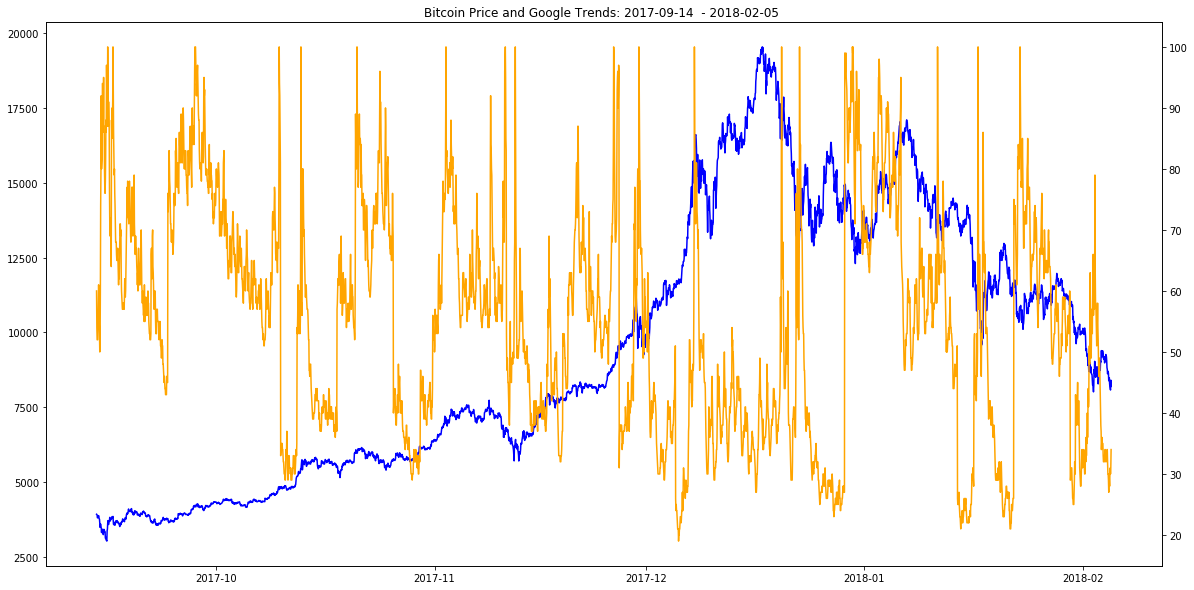

In [19]:
import matplotlib.pyplot as plt

# visualize Bitcoin's recent super spike starting Sep 2017 
sep_2017_to_feb_2018_df = btc_and_trends_df_hourly[ (btc_and_trends_df_hourly["Timestamp"] > 1505347200) & (btc_and_trends_df_hourly["Timestamp"] <=  1517788800) ]
#display(sep_2017_to_feb_2018_df)

fig_bitcoin_spike, ax_bitcoin_spike = plt.subplots(figsize=(20,10)) 
ax_bitcoin_spike.plot(sep_2017_to_feb_2018_df["Date(UTC)"], sep_2017_to_feb_2018_df["Close"], color='blue')
ax_bitcoin_spike_2 = ax_bitcoin_spike.twinx() 
ax_bitcoin_spike_2.plot(sep_2017_to_feb_2018_df["Date(UTC)"], sep_2017_to_feb_2018_df["Bitcoin"], color='orange' )
ax_bitcoin_spike.set_title('Bitcoin Price and Google Trends: ' + str(sep_2017_to_feb_2018_df["Date(UTC)"].iloc[0])[:-8] + ' - ' + str(sep_2017_to_feb_2018_df["Date(UTC)"].iloc[-1])[:-8] )
for tick in ax_bitcoin_overall.get_xticklabels():
    tick.set_rotation(90)
plt.show();

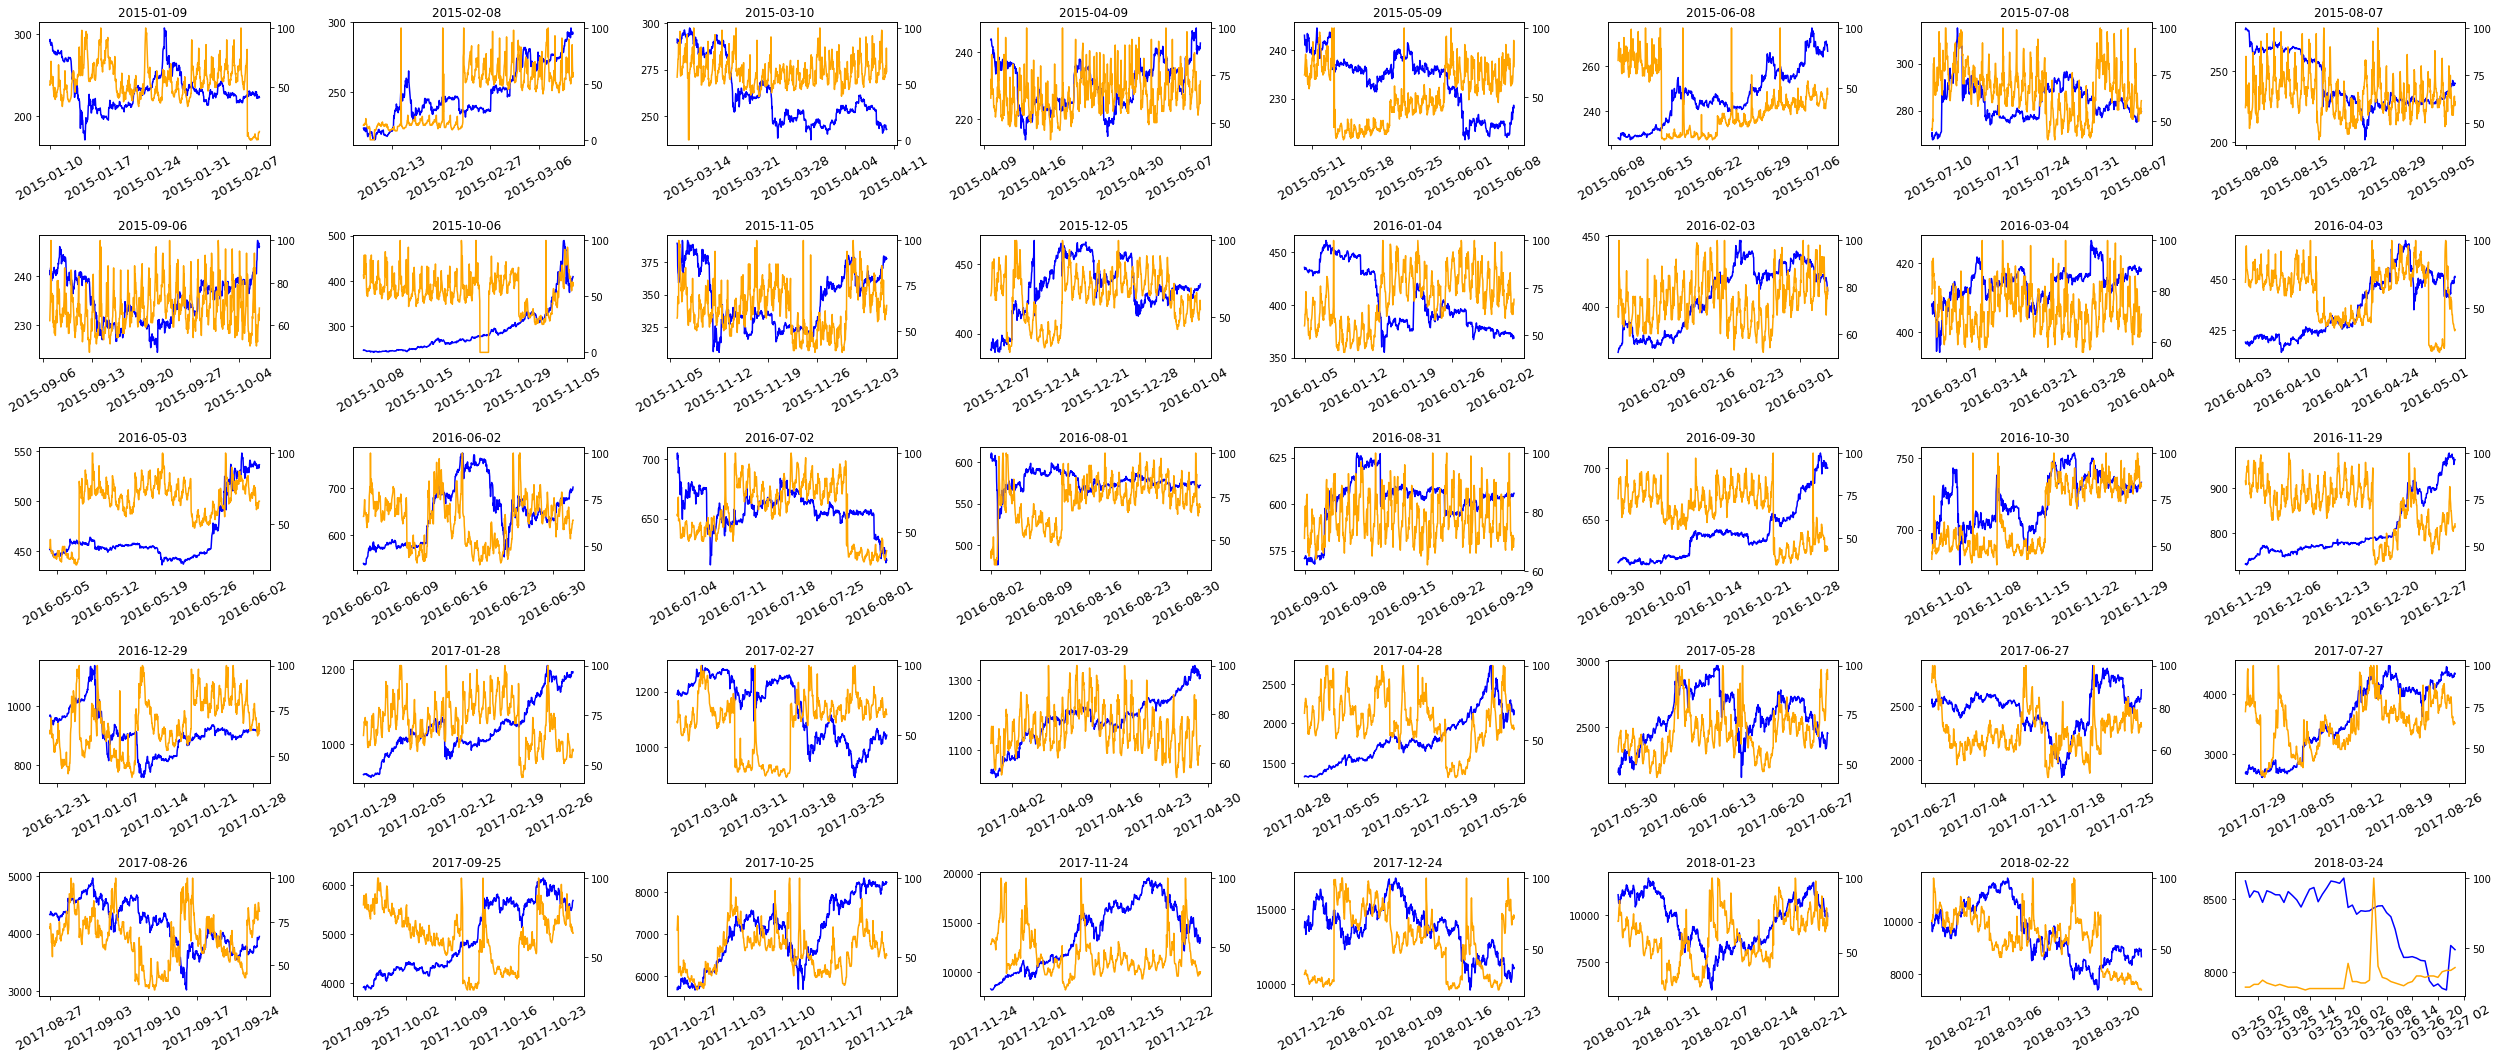

In [20]:
# from sklearn import preprocessing
# min_max_scaler=preprocessing.MinMaxScaler()

#change so that it just creates a new column

# btc_and_trends_df_hourly[['close_normalized','bitcoin_normalized']] = btc_and_trends_df_hourly[['Close','Bitcoin']]

# btc_and_trends_df_hourly[['close_normalized','bitcoin_normalized']] = min_max_scaler.fit_transform(btc_and_trends_df_hourly[['close_normalized','bitcoin_normalized']])
# btc_and_trends_df_hourly.head()

# fig, ax = plt.subplots()
# ax.plot(btc_and_trends_df_hourly["Date"], btc_and_trends_df_hourly["close_normalized"])
# ax.plot(btc_and_trends_df_hourly["Date"], btc_and_trends_df_hourly["bitcoin_normalized"])
# ax.set_title("Bitcoin Close Prices and Google Trends Normalized")
# ax.set(ylabel="price and trend, scaled to 0-1",xlabel="time")
# plt.show()

fig, axes = plt.subplots(nrows=5, ncols=8, figsize=(35,15), sharex=False, sharey=False)

start_timestamp = btc_and_trends_df_hourly["Timestamp"][0] 
end_timestamp = btc_and_trends_df_hourly["Timestamp"].iloc[-1] 

for i, ax in enumerate(axes.flatten()):
    in_range_df = btc_and_trends_df_hourly[ (btc_and_trends_df_hourly["Timestamp"] > start_timestamp) & (btc_and_trends_df_hourly["Timestamp"] <= start_timestamp+2592000) ]
    ax.plot(in_range_df["Date(UTC)"], in_range_df["Close"], color='blue')
    ax2 = ax.twinx() 
    ax2.plot(in_range_df["Date(UTC)"], in_range_df["Bitcoin"], color='orange' )
    ax.set_title(str(in_range_df["Date(UTC)"].iloc[0])[:-8])
    start_timestamp += 2592000
    for tick in ax.get_xticklabels():
        tick.set_rotation(30)
        tick.set_fontsize(13)
        
#     labels = [item.get_text() for item in ax.get_xticklabels()]
#     labels_modified = [label[5:] for label in labels] 
#     ax.set_xticklabels(labels_modified)
        
#         tick_label = tick.get_text()
#         display(tick_label)
#         tick.set_text(tick_label[5:]) Doesnt work!
    
plt.rcParams.update({'font.size': 16})
fig.tight_layout()
plt.show();

# Orange is Google Trends Hourly Data for the keyword 'Bitcoin'
# Blue is Bitcoin Hourly Close Data 

In [28]:
from luminol.anomaly_detector import AnomalyDetector 
from luminol.correlator import Correlator

# Convert dataframe into dictionary to put into luminol
timestamp_close_df = btc_and_trends_df_hourly[['Timestamp', 'Close']]
timestamp_bitcoin_trend_df = btc_and_trends_df_hourly[['Timestamp', 'Bitcoin']]
display(timestamp_close_df.head())
display(timestamp_bitcoin_trend_df.head())

timestamp_close_dict = timestamp_close_df.set_index('Timestamp')['Close'].to_dict()
timestamp_bitcoin_trend_dict = timestamp_bitcoin_trend_df.set_index('Timestamp')['Bitcoin'].to_dict()

# anomaly detector 
anomaly_detector = AnomalyDetector(timestamp_close_dict)
score = anomaly_detector.get_all_scores()

for timestamp, value in score.iteritems():
    # print anomaly score if greater than 0 
    if (value > 0 ):
        readable_date = datetime.fromtimestamp(timestamp).strftime('%Y-%m-%d %H')
        print(readable_date,'->', value)
    
# correlate Close price and Google Trends
anomalies = anomaly_detector.get_anomalies()
for anomaly in anomalies:
    time_period = anomaly.get_time_window()
    
    # to do: tweek the parameters for correlator (like the shift allowed)
    correlator = Correlator(timestamp_close_dict, timestamp_bitcoin_trend_dict, time_period)
    if correlator.is_correlated(threshold=0.5):
        print("Trend data correlate with Price at time period (%d, %d)" % time_period)

print('There were '+ str(len(anomalies))+ ' anomalies')

,Timestamp,Close
0,1420840800,289.13
1,1420844400,292.15
2,1420848000,293.89
3,1420851600,289.10
4,1420855200,288.59


,Timestamp,Bitcoin
0,1420840800,53
1,1420844400,52
2,1420848000,52
3,1420851600,56
4,1420855200,53


2017-10-04 03 -> 86.0
2017-10-04 04 -> 114.0
2017-10-04 05 -> 146.0
2017-10-04 06 -> 182.0
2017-10-04 07 -> 222.0
2017-10-04 08 -> 266.0
2017-10-04 09 -> 314.0
2017-10-04 10 -> 366.0
2017-10-04 11 -> 422.0
2017-10-04 12 -> 482.0
2017-10-04 13 -> 546.0
2017-10-04 14 -> 614.0
2017-10-04 15 -> 686.0
2017-10-04 16 -> 762.0
2017-10-04 17 -> 842.0
2017-10-04 18 -> 926.0
2017-10-04 19 -> 1014.0
2017-10-04 20 -> 1106.0
2017-10-04 21 -> 1202.0
2017-10-04 22 -> 1302.0
2017-10-04 23 -> 1406.0
2017-10-05 00 -> 1514.0
2017-10-05 01 -> 1626.0
2017-10-05 02 -> 1742.0
2017-10-05 03 -> 1862.0
2017-10-05 04 -> 1986.0
2017-10-05 05 -> 2114.0
2017-10-05 06 -> 2246.0
2017-10-05 07 -> 2382.0
2017-10-05 08 -> 2522.0
2017-10-05 09 -> 2666.0
2017-10-05 10 -> 2814.0
2017-10-05 11 -> 2966.0
2017-10-05 12 -> 3122.0
2017-10-05 13 -> 3282.0
2017-10-05 14 -> 3446.0
2017-10-05 15 -> 3614.0
2017-10-05 16 -> 3786.0
2017-10-05 17 -> 3962.0
2017-10-05 18 -> 4142.0
2017-10-05 19 -> 4326.0
2017-10-05 20 -> 4514.0
2017-10-0

2017-12-10 09 -> 44466.0
2017-12-10 10 -> 44186.0
2017-12-10 11 -> 43594.0
2017-12-10 12 -> 43006.0
2017-12-10 13 -> 42422.0
2017-12-10 14 -> 41842.0
2017-12-10 15 -> 41266.0
2017-12-10 16 -> 40694.0
2017-12-10 17 -> 40428.0
2017-12-10 18 -> 40734.0
2017-12-10 19 -> 41042.0
2017-12-10 20 -> 40782.0
2017-12-10 21 -> 40214.0
2017-12-10 22 -> 39650.0
2017-12-10 23 -> 39090.0
2017-12-11 00 -> 38534.0
2017-12-11 01 -> 37982.0
2017-12-11 02 -> 37434.0
2017-12-11 03 -> 36890.0
2017-12-11 04 -> 36350.0
2017-12-11 05 -> 35814.0
2017-12-11 06 -> 35282.0
2017-12-11 07 -> 34754.0
2017-12-11 08 -> 34230.0
2017-12-11 09 -> 33710.0
2017-12-11 10 -> 33194.0
2017-12-11 11 -> 32682.0
2017-12-11 12 -> 32174.0
2017-12-11 13 -> 31670.0
2017-12-11 14 -> 31170.0
2017-12-11 15 -> 30674.0
2017-12-11 16 -> 30182.0
2017-12-11 17 -> 29694.0
2017-12-11 18 -> 29210.0
2017-12-11 19 -> 28730.0
2017-12-11 20 -> 28254.0
2017-12-11 21 -> 27782.0
2017-12-11 22 -> 27314.0
2017-12-11 23 -> 26850.0
2017-12-12 00 -> 26390.0


2018-01-08 19 -> 26222.0
2018-01-08 20 -> 26918.0
2018-01-08 21 -> 27854.0
2018-01-08 22 -> 28806.0
2018-01-08 23 -> 29774.0
2018-01-09 00 -> 30758.0
2018-01-09 01 -> 31758.0
2018-01-09 02 -> 32774.0
2018-01-09 03 -> 33546.0
2018-01-09 04 -> 34328.0
2018-01-09 05 -> 35120.0
2018-01-09 06 -> 35920.0
2018-01-09 07 -> 36200.0
2018-01-09 08 -> 36750.0
2018-01-09 09 -> 37574.0
2018-01-09 10 -> 38146.0
2018-01-09 11 -> 38730.0
2018-01-09 12 -> 39326.0
2018-01-09 13 -> 40194.0
2018-01-09 14 -> 41334.0
2018-01-09 15 -> 42490.0
2018-01-09 16 -> 43662.0
2018-01-09 17 -> 44574.0
2018-01-09 18 -> 44898.0
2018-01-09 19 -> 44898.0
2018-01-09 20 -> 44898.0
2018-01-09 21 -> 44898.0
2018-01-09 22 -> 44898.0
2018-01-09 23 -> 44898.0
2018-01-10 00 -> 44898.0
2018-01-10 01 -> 44898.0
2018-01-10 02 -> 44898.0
2018-01-10 03 -> 44898.0
2018-01-10 04 -> 44898.0
2018-01-10 05 -> 44898.0
2018-01-10 06 -> 44898.0
2018-01-10 07 -> 44898.0
2018-01-10 08 -> 44898.0
2018-01-10 09 -> 44898.0
2018-01-10 10 -> 44898.0


2018-02-07 17 -> 1256.0
2018-02-07 18 -> 1064.0
2018-02-07 19 -> 888.0
2018-02-07 20 -> 762.0
2018-02-07 21 -> 650.0
2018-02-07 22 -> 514.0
2018-02-07 23 -> 422.0
2018-02-08 00 -> 366.0
2018-02-08 01 -> 294.0
2018-02-08 02 -> 206.0
2018-02-08 03 -> 134.0
2018-02-08 04 -> 94.0
2018-02-08 12 -> 110.0
2018-02-08 13 -> 166.0
2018-02-08 14 -> 238.0
2018-02-08 15 -> 326.0
2018-02-08 16 -> 430.0
2018-02-08 17 -> 550.0
2018-02-08 18 -> 686.0
2018-02-08 19 -> 838.0
2018-02-08 20 -> 1006.0
2018-02-08 21 -> 1190.0
2018-02-08 22 -> 1390.0
2018-02-08 23 -> 1606.0
2018-02-09 00 -> 1838.0
2018-02-09 01 -> 2086.0
2018-02-09 02 -> 2350.0
2018-02-09 03 -> 2630.0
2018-02-09 04 -> 2926.0
2018-02-09 05 -> 3238.0
2018-02-09 06 -> 3566.0
2018-02-09 07 -> 3910.0
2018-02-09 08 -> 4270.0
2018-02-09 09 -> 4646.0
2018-02-09 10 -> 5038.0
2018-02-09 11 -> 5446.0
2018-02-09 12 -> 5774.0
2018-02-09 13 -> 5990.0
2018-02-09 14 -> 6210.0
2018-02-09 15 -> 6434.0
2018-02-09 16 -> 6662.0
2018-02-09 17 -> 6894.0
2018-02-09 

2018-03-03 06 -> 2196.0
2018-03-03 07 -> 2468.0
2018-03-03 08 -> 2690.0
2018-03-03 09 -> 2926.0
2018-03-03 10 -> 3170.0
2018-03-03 11 -> 3330.0
2018-03-03 12 -> 3494.0
2018-03-03 13 -> 3662.0
2018-03-03 14 -> 3834.0
2018-03-03 15 -> 4010.0
2018-03-03 16 -> 4190.0
2018-03-03 17 -> 4374.0
2018-03-03 18 -> 4562.0
2018-03-03 19 -> 4754.0
2018-03-03 20 -> 4950.0
2018-03-03 21 -> 5150.0
2018-03-03 22 -> 5354.0
2018-03-03 23 -> 5562.0
2018-03-04 00 -> 5774.0
2018-03-04 01 -> 5990.0
2018-03-04 02 -> 6210.0
2018-03-04 03 -> 6434.0
2018-03-04 04 -> 6662.0
2018-03-04 05 -> 6894.0
2018-03-04 06 -> 7130.0
2018-03-04 07 -> 7370.0
2018-03-04 08 -> 7614.0
2018-03-04 09 -> 7862.0
2018-03-04 10 -> 8114.0
2018-03-04 11 -> 8370.0
2018-03-04 12 -> 8630.0
2018-03-04 13 -> 8894.0
2018-03-04 14 -> 9314.0
2018-03-04 15 -> 9866.0
2018-03-04 16 -> 10434.0
2018-03-04 17 -> 11018.0
2018-03-04 18 -> 11618.0
2018-03-04 19 -> 12234.0
2018-03-04 20 -> 12866.0
2018-03-04 21 -> 13514.0
2018-03-04 22 -> 14178.0
2018-03-0

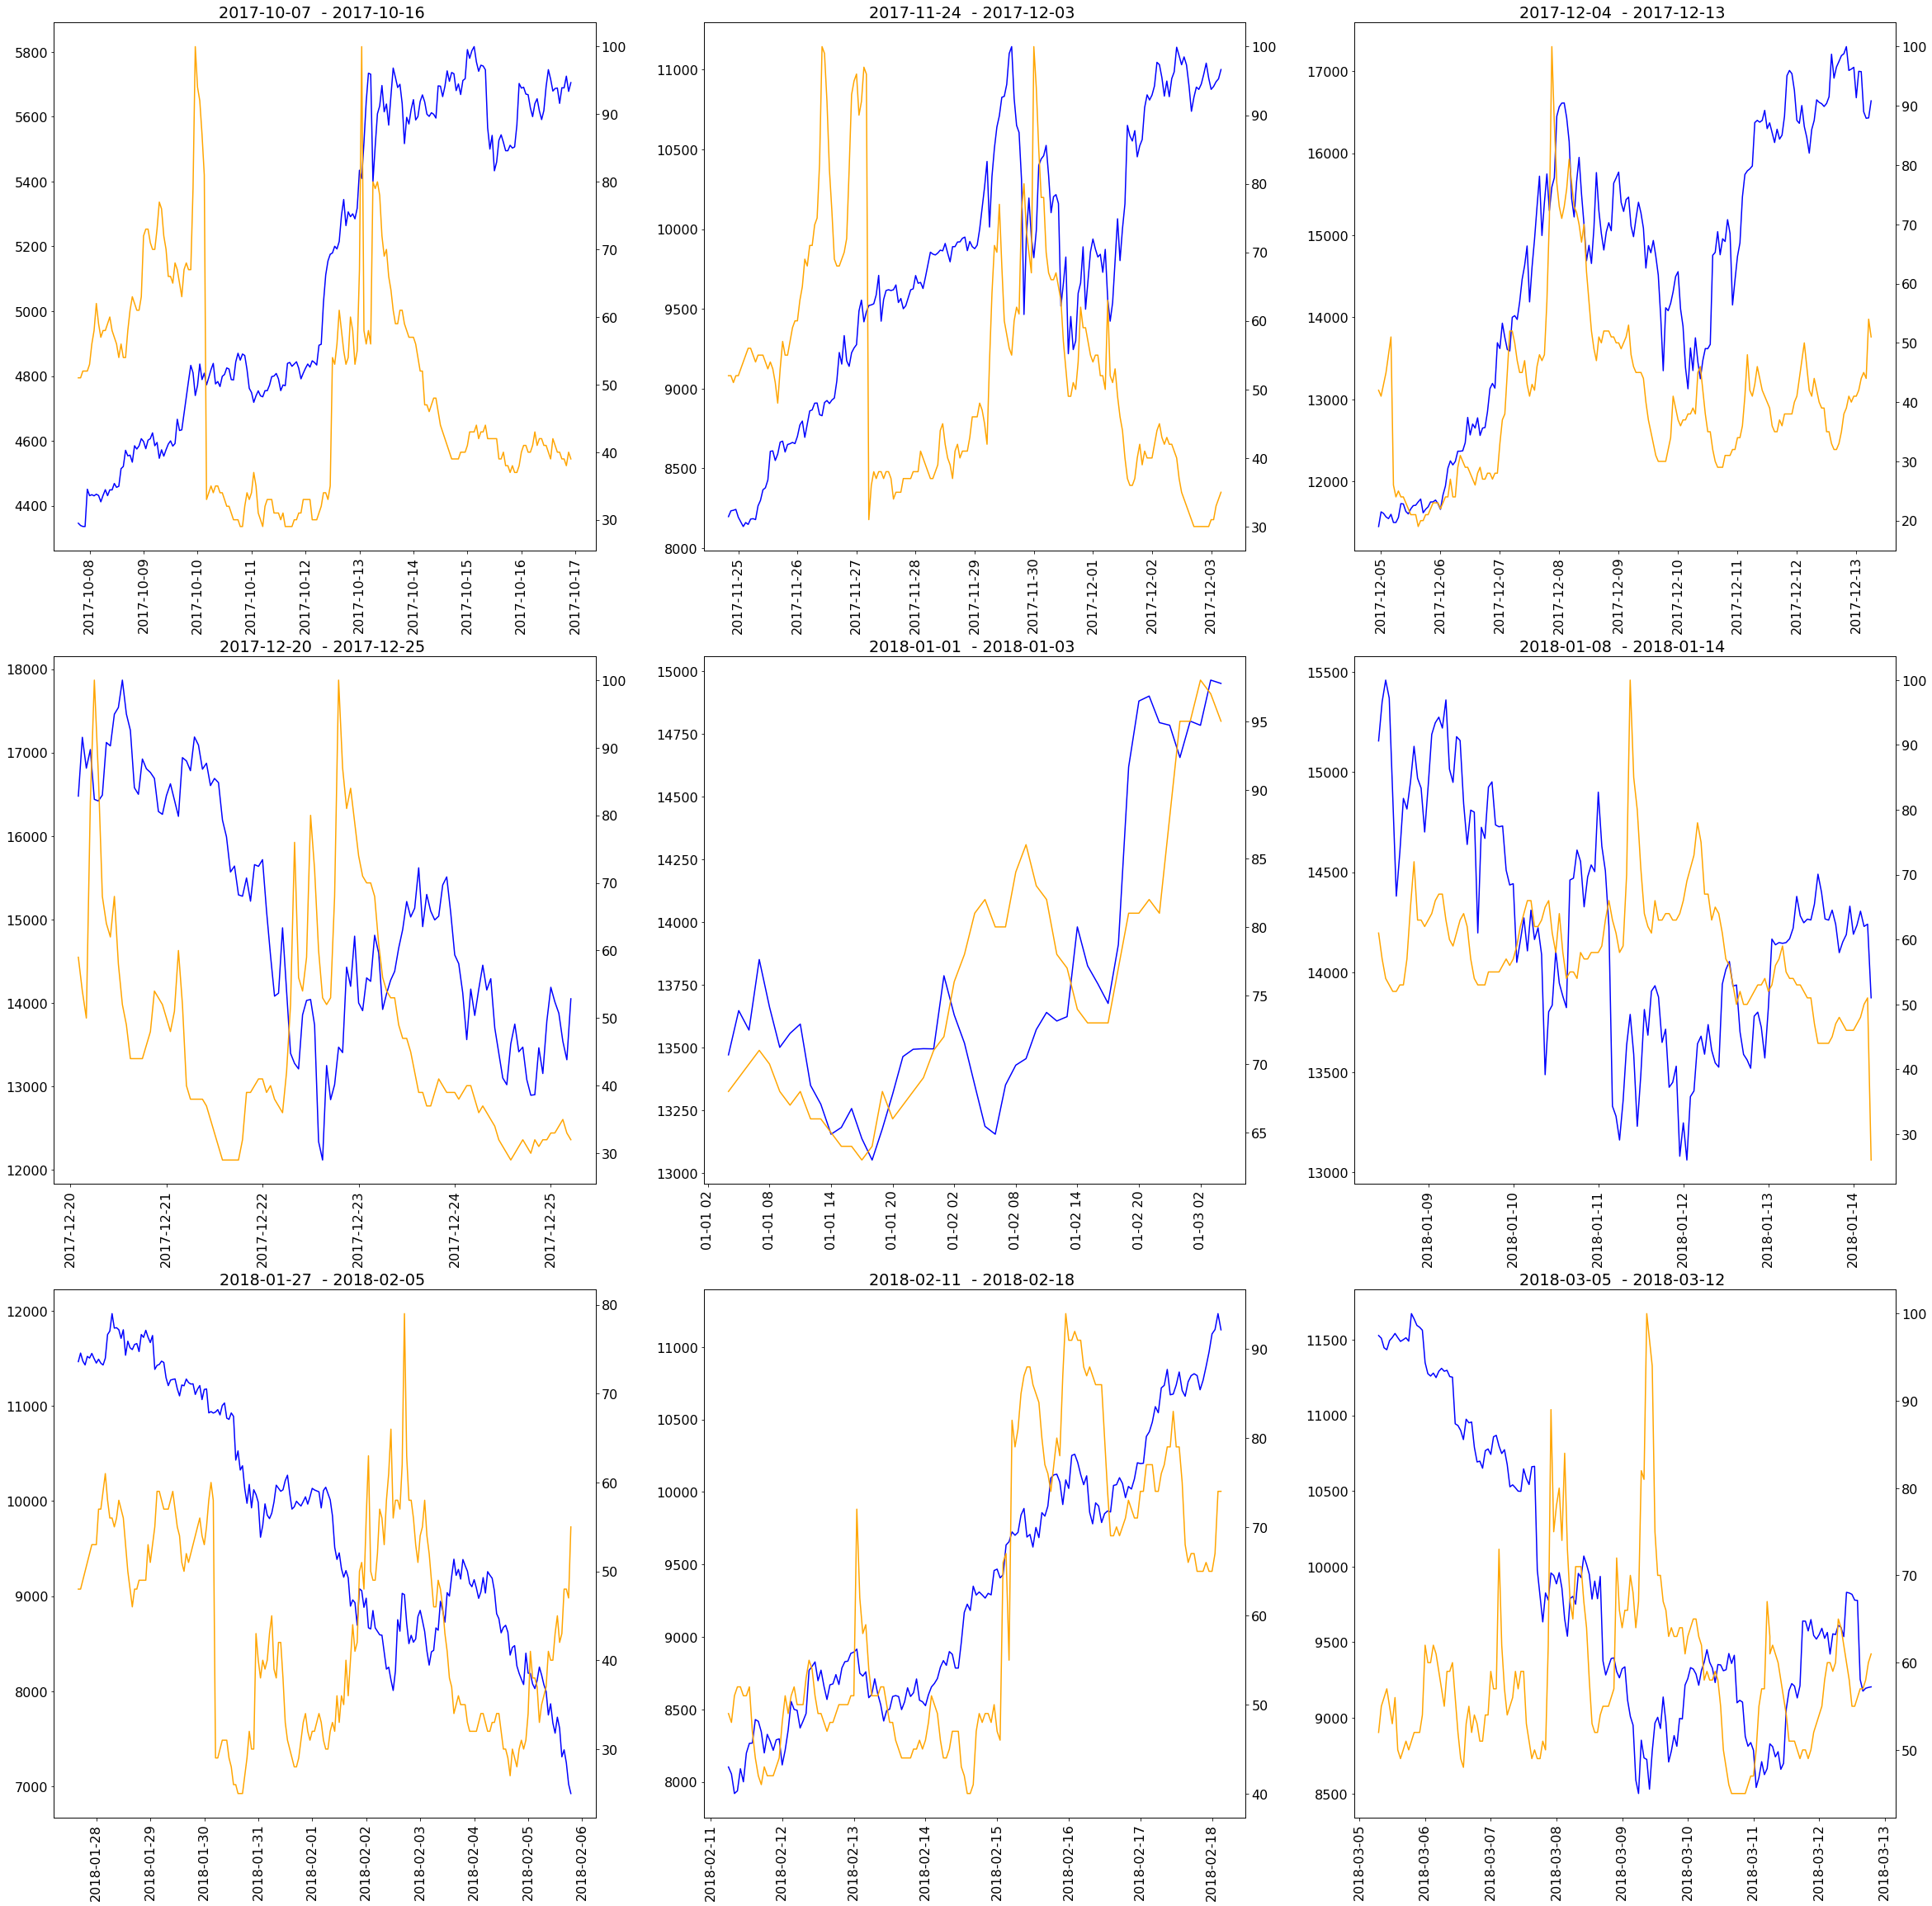

In [25]:
# plots all the anomalies

fig2, axes2 = plt.subplots(nrows=3, ncols=3, figsize=(40,40), sharex=False, sharey=False)

#for i, anomaly in enumerate(anomalies):
for i, ax in enumerate(axes2.flatten()):    
    time_period = anomalies[i].get_time_window()
    start_timestamp = time_period[0]
    end_timestamp = time_period[1] 
        
    in_range_df = btc_and_trends_df_hourly[ (btc_and_trends_df_hourly["Timestamp"] > start_timestamp) & (btc_and_trends_df_hourly["Timestamp"] <= end_timestamp) ]
    #display(in_range_df)
    ax.plot(in_range_df["Date(UTC)"], in_range_df["Close"], color='blue')
    ax2 = ax.twinx() 
    ax2.plot(in_range_df["Date(UTC)"], in_range_df["Bitcoin"], color='orange' )
    ax.set_title(str(in_range_df["Date(UTC)"].iloc[0])[:-8] + ' - ' + str(in_range_df["Date(UTC)"].iloc[-1])[:-8] )
    for tick in ax.get_xticklabels():
        tick.set_rotation(90)
    
fig.tight_layout()
fig.subplots_adjust(hspace=2)
plt.show();

# Blue is Price, Orange is Trend. 

In [ ]:
# to do: find out when google trend data had anomalies 